# importing the libraries 

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy as scipy
import json
import networkx as nx
from scipy.spatial import KDTree
import pulp

# importing the data 

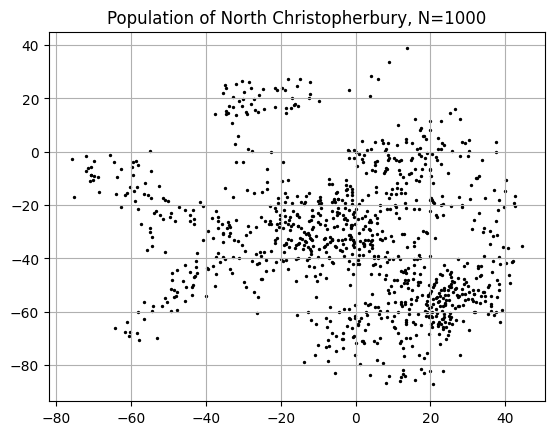

In [129]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[6]

with open('./data/population_{}.json'.format(city_name), 'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))
plt.grid(True)

# defining the evaluate coverage function 

In [130]:
def evaluate_coverage(data, placement, R_dist):
    x = np.array(data['x'])
    y = np.array(data['y'])
    B = len(x)
    coords = np.array([[x[i], y[i]] for i in range(len(x))])
    cost = 0
    for i in range(len(placement)):
        coord_i = np.array([placement[i]])
        for j in range(len(placement)):
            coord_j = np.array([placement[j]])
            if i != j:
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)
                if dist < (2 + 1e-3)*R_dist:
                    cost += -B


        dist = scipy.spatial.distance.cdist(coord_i, coords)
        cov = np.sum(dist < R_dist)
        cost += cov

    if cost < 0:
        return -np.inf
    else:
        return cost

# options for the grid 

In [131]:
#triangular grid 

In [132]:
def generate_triangular_grid(side_lengths, spacing, offset):
    rows, cols = side_lengths
    points = []
    for row in range(rows):
        for col in range(cols):
            # Calculate the x coordinate
            x = col * spacing
            # Offset every other row by half the side length
            if row % 2 == 1:
                x += spacing / 2
            # Calculate the y coordinate based on the row number
            y = row * (spacing * (3**0.5) / 2)  # Height of an equilateral triangle
            points.append([x + offset[0], y + offset[1]])
    return points 

# importing the parameters 

In [ ]:
population_x = x # x coordinates of the population
population_y = y # y coordinates of the population
R_antennas = 25  # Operating radius for each antenna
max_antennas = 70  # Maximum number of antennas
minimum_coverage = 0.7 * len(population_x) # Minimum coverage of the population required

# implementing the grid parameters and the limit per city 

In [ ]:
spacing = 1.2*R_antennas  # Spacing between antennas
offset = (population_x.min(), population_y.min())  # Offset for the grid
side_lengths = (int(np.ceil((population_x.max() - population_x.min())/spacing)), int(np.ceil((population_y.max() - population_y.min())/spacing)))  # Number of antennas in each direction
grid_points = generate_triangular_grid(side_lengths=side_lengths, spacing=spacing, offset=offset)  # Generate the grid points
per_city_limit = 7 

# evaluating the coverage 

In [140]:
z_coverage = np.zeros(len(grid_points))
coords = np.array([[population_x[i], population_y[i]] for i in range(len(x))])
for i in range(len(grid_points)):
    # val_y = y_test[i,j]
    start = np.array(grid_points[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

# plotting 

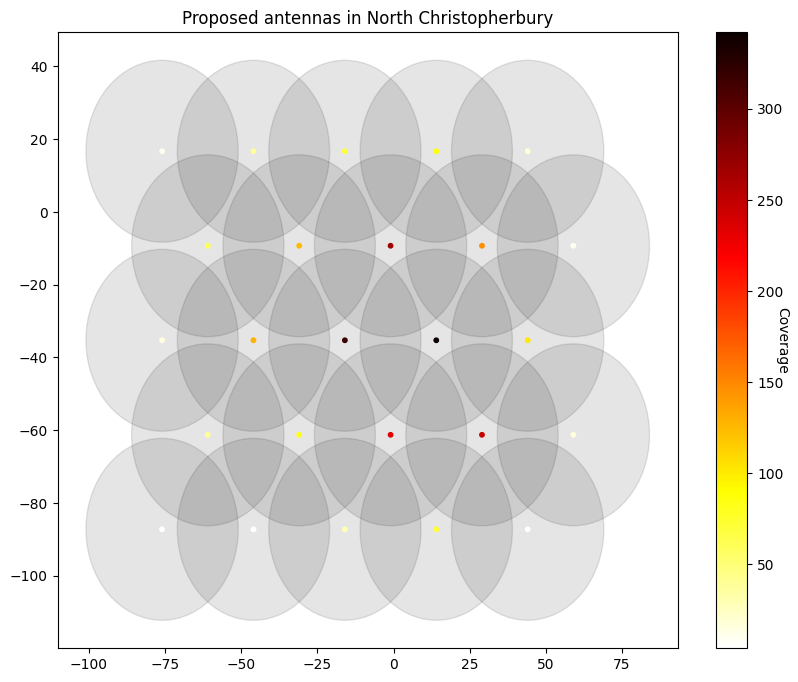

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plt.title('Proposed antennas in {}'.format(city_name))
ind = 0
for (xi, yi) in zip(np.array(grid_points)[:,0], np.array(grid_points)[:,1]):
    if z_coverage[ind] > 1e-3:
        circle = patches.Circle((xi, yi), R_antennas, edgecolor='black', facecolor='black', transform=ax.transData, alpha = 0.1)
        ax.add_patch(circle)
    ind += 1
scatter = ax.scatter(np.array(grid_points)[:,0], np.array(grid_points)[:,1], s=10, c = z_coverage, cmap = 'hot_r')

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Coverage', rotation=270)

{15: Text(-60.98006777389247, -9.291462685491112, '15'),
 21: Text(-45.98006777389247, 16.689299428042048, '21'),
 6: Text(-30.980067773892472, -61.25298691255742, '6'),
 12: Text(-15.980067773892472, -35.272224799024265, '12'),
 18: Text(29.019932226107528, -9.291462685491112, '18'),
 23: Text(14.019932226107528, 16.689299428042048, '23'),
 3: Text(14.019932226107528, -87.23374902609058, '3'),
 4: Text(44.01993222610753, -87.23374902609058, '4'),
 9: Text(59.01993222610753, -61.25298691255742, '9'),
 16: Text(-30.980067773892472, -9.291462685491112, '16'),
 7: Text(-0.9800677738924719, -61.25298691255742, '7'),
 22: Text(-15.980067773892472, 16.689299428042048, '22'),
 13: Text(14.019932226107528, -35.272224799024265, '13'),
 5: Text(-60.98006777389247, -61.25298691255742, '5'),
 10: Text(-75.98006777389247, -35.272224799024265, '10'),
 8: Text(29.019932226107528, -61.25298691255742, '8'),
 14: Text(44.01993222610753, -35.272224799024265, '14'),
 19: Text(59.01993222610753, -9.2914626

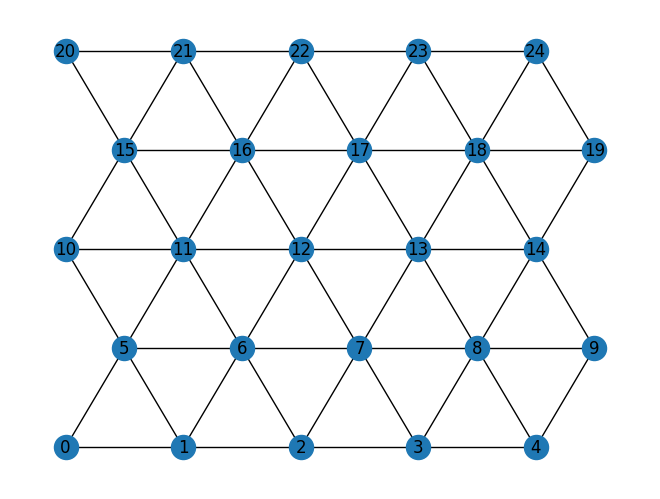

In [136]:
graph = nx.Graph()
edges = KDTree(grid_points).query_pairs(R_antennas * (2 + 1e-3))
graph.add_edges_from(edges)
nx.draw(graph, pos=grid_points)
nx.draw_networkx_labels(graph, pos=grid_points)

In [137]:
# Set up the ILP problem using PuLP
problem = pulp.LpProblem("Antenna_Placement_Optimization", pulp.LpMaximize)

# Decision variables
z = pulp.LpVariable.dicts("z", range(len(grid_points)), cat='Binary')
c = pulp.LpVariable.dicts(f"c", range(len(population_x)), cat='Binary')
y = pulp.LpVariable.dicts("y", edges, cat='Binary')


# Objective function
B = len(population_x)  # Penalty for interference
problem += (
    pulp.lpSum(c[j] for j in range(len(population_x))) - 
    B * pulp.lpSum(y[i, j] for i, j in edges),
    "Maximize_Coverage"
)

# Constraints
# Coverage constraint
for j in range(len(population_x)):
    population_coord = np.array([population_x[j], population_y[j]])
    covering_antennas = [
        i for i in range(len(grid_points)) 
        if np.linalg.norm(grid_points[i] - population_coord) <= R_antennas
    ]
    problem += (c[j] <= pulp.lpSum(z[i] for i in covering_antennas), f"Coverage_Constraint_{j}")

# Minimum coverage requirement
problem += (pulp.lpSum(c[j] for j in range(len(population_x))) >= minimum_coverage, "Minimum_Coverage")

# Interference constraints
for i, j in edges:
    problem += (y[i, j] >= z[i] + z[j] - 1, f"Interference_Constraint_{i}_{j}")

# Antenna count constraint
problem += (pulp.lpSum(z[i] for i in range(len(grid_points))) <= 70, "Max_Antennas")

# Coverage constraints for each city
for city in cities:
    for j in range(len(population_x)):
        population_coord = np.array([population_x[j], population_y[j]])
        covering_antennas = [
            i for i in range(len(grid_points)) 
            if np.linalg.norm(grid_points[i] - population_coord) <= R_antennas
        ]
        problem += (c[j] <= pulp.lpSum(z[i] for i in covering_antennas), f"Coverage_Constraint_{city}_{j}")

    # Per city antenna count constraint (up to 7 antennas)
    problem += (pulp.lpSum(z[i] for i in range(len(grid_points))) <= per_city_limit, f"Max_Antennas_{city}")

In [138]:
# Solve the problem using GLPK
# solver = pulp.PULP_CBC_CMD()
solver = pulp.GLPK_CMD()
problem.solve(solver)

# Display results
print("Status:", pulp.LpStatus[problem.status])
print("Total Coverage:", pulp.value(problem.objective))

selected_antennas = [i for i in range(len(grid_points)) if z[i].value() == 1]
print("Number of Antennas Placed:", len(selected_antennas))
print("Antenna Positions (selected):", [grid_points[i] for i in selected_antennas])


Status: Optimal
Total Coverage: 908
Number of Antennas Placed: 7
Antenna Positions (selected): [[-15.980067773892472, -87.23374902609058], [-60.98006777389247, -61.25298691255742], [29.019932226107528, -61.25298691255742], [-15.980067773892472, -35.272224799024265], [-60.98006777389247, -9.291462685491112], [29.019932226107528, -9.291462685491112], [-15.980067773892472, 16.689299428042048]]


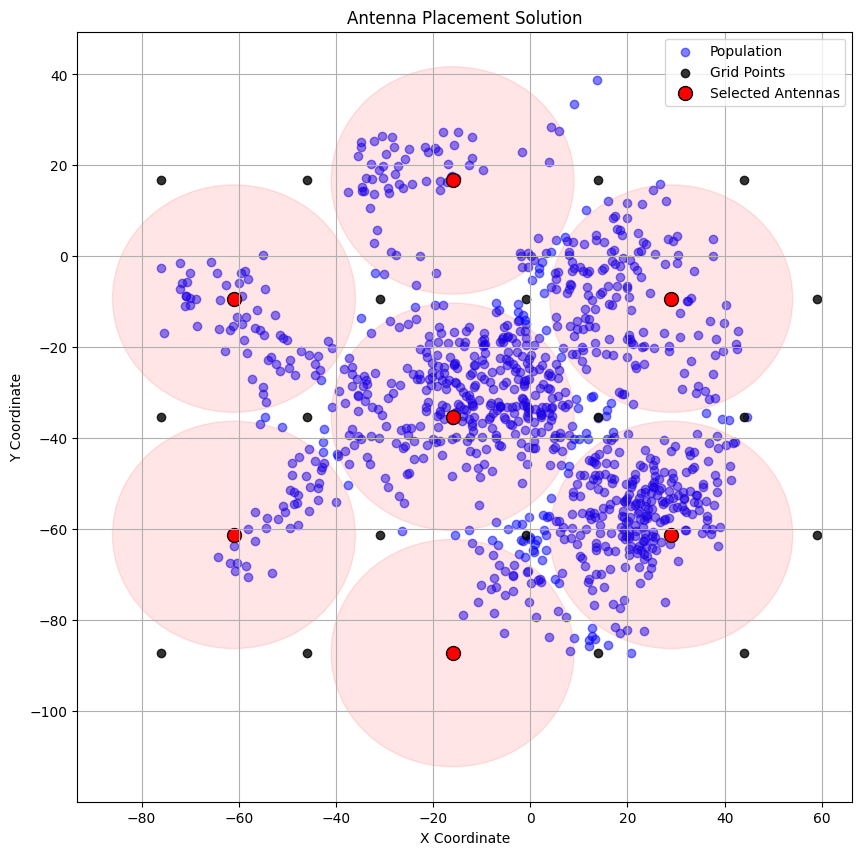

Population coverage: 908 out of 1000
Evaluation coverage: 908


In [139]:
# Plot the solution with selected antennas
plt.figure(figsize=(10, 10))

# Plot population points
plt.scatter(population_x, population_y, c='blue', label='Population', alpha=0.5)

# Plot all candidate grid points
plt.scatter(np.array(grid_points)[:,0], np.array(grid_points)[:, 1], c='black', label='Grid Points', alpha=0.8)

# Highlight the selected antennas
selected_antennas_positions = [grid_points[i] for i in selected_antennas]
selected_antennas_x = [pos[0] for pos in selected_antennas_positions]
selected_antennas_y = [pos[1] for pos in selected_antennas_positions]
plt.scatter(selected_antennas_x, selected_antennas_y, c='red', label='Selected Antennas', s=100, edgecolors='black')

# Plot coverage circles for selected antennas
for pos in selected_antennas_positions:
    circle = plt.Circle((pos[0], pos[1]), R_antennas, color='red', alpha=0.1)
    plt.gca().add_patch(circle)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Antenna Placement Solution')
plt.legend()
plt.grid(True)
plt.show()

score = evaluate_coverage(data, selected_antennas_positions, R_antennas)
population_coverage = np.sum([c[i].value() for i in range(len(c))])
print(f'Population coverage: {population_coverage} out of {len(population_x)}')
print(f'Evaluation coverage: {score}')